In [262]:
#get dataframe of tweet_id and user_id
import pandas as pd
import csv
from twython import Twython
import time
from collections import defaultdict

df = pandas.read_csv('gamergate_tweets.csv')
user_ids = df['user_id'].tolist()[:5000]

# Consumer & Auth keys and tokens for authentication
CONSUMER_KEY = "48r56upQvsnTiSDfY4CNwIpCQ"
CONSUMER_SECRET = "VqZhFW7GqogdKXJnpuS0umVe211bFgoCdaQlRdRMayvrbdDh3k"
OAUTH_TOKEN = "18000528-Scl8a1pLinqP4KWtaa3f8EN0M1vqAGTyYXMtsLIGm"
OAUTH_TOKEN_SECRET = "NcIvLeqVbwwBegabvo7946FVIaDN0CAaJ7aS2aV7pZFzC"

twitter = Twython(CONSUMER_KEY, CONSUMER_SECRET, OAUTH_TOKEN, OAUTH_TOKEN_SECRET)

# check rate limit
# twitter.get_application_rate_limit_status()['resources']['followers']

In [266]:
# Get followers/id 2
def test(twitter, user_id):
    follower_ids = []
    # Fetch the followings as a cursored collection (up to 5000 per call).
    cursor = -1
    #follower_ids = twitter.get_followers_ids(user_id=user_id, cursor=cursor)
    remaining = twitter.get_application_rate_limit_status()['resources']['followers']['/followers/ids']['remaining']
    while cursor != 0:
        if remaining < 2:
            print "start waiting ", cursor
            time.sleep(920)
            print "done waiting"
            twitter = Twython(CONSUMER_KEY, CONSUMER_SECRET, OAUTH_TOKEN, OAUTH_TOKEN_SECRET)
            remaining = twitter.get_application_rate_limit_status()['resources']['followers']['/followers/ids']['remaining']
            print remaining
        else:
            twitter = Twython(CONSUMER_KEY, CONSUMER_SECRET, OAUTH_TOKEN, OAUTH_TOKEN_SECRET)
            resp = twitter.get_followers_ids(user_id=user_id, cursor=cursor)
            follower_ids += resp['ids']
            cursor = resp['next_cursor']
            remaining = twitter.get_application_rate_limit_status()['resources']['followers']['/followers/ids']['remaining']
            print remaining
    return follower_ids

# GET followers/list
def get_follower_list(twitter, user_id):
    followers = []
    print twitter.get_application_rate_limit_status()['resources']['followers']['/followers/list']['remaining']
    cursored = twitter.cursor(twitter.get_followers_list, id=user_id)
    print twitter.get_application_rate_limit_status()['resources']['followers']['/followers/list']['remaining']
    for follower in cursored:
        followers.append(follower)
    return followers

# GET users/lookup
def get_user_lookup(twitter, current):
    user_obj = twitter.lookup_user(user_id=current)
    return user_obj
    
# GET followers/ids
def get_follower_ids(twitter, user_id):
    followers = []
    cursored = twitter.cursor(twitter.get_followers_ids, id=user_id)
    for follower in cursored:
        followers.append(follower)
    return followers

In [4]:
user_list = []
start = 0
end = 100
while end <= 5000:
    current = user_ids[start:end]
    start += 100
    end += 100
    users = get_user_lookup(twitter, current)
    for i in range(0, len(users)):
        each_user = []
        each_user.append(user_ids[i]) # user[0] = user_id
        each_user.append(users[i]['followers_count']) # user[1] = follower count
        each_user.append(users[i]['favourites_count'])
        each_user.append(users[i]['location'])
        user_list.append(each_user)

In [5]:
users_df = pandas.DataFrame(user_list, columns=["User ID", "Follower Count", "Favourites Count", "Location"])
tweets_df = pandas.read_csv("all_tweets.csv")
print tweets_df.info()
#print users_df.sort_values(["Follower Count", "Favourites Count",], ascending=[False, False])

<class 'pandas.core.frame.DataFrame'>
Int64Index: 429367 entries, 0 to 429366
Data columns (total 9 columns):
User ID        270866 non-null object
Retweets       270873 non-null float64
Favorites      270873 non-null float64
Has_url        270871 non-null float64
Mentions       270852 non-null object
Text           270813 non-null object
Polarity       206309 non-null float64
Popularity     206309 non-null float64
numMentions    206309 non-null float64
dtypes: float64(6), object(3)
memory usage: 32.8+ MB
None


/Users/Minying/envs/cs591-datamining/lib/python2.7/site-packages/IPython/core/interactiveshell.py:2902: DtypeWarning: Columns (0,4,5) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [6]:
from sklearn.decomposition import TruncatedSVD
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import Normalizer
from sklearn import metrics

from sklearn.cluster import KMeans, MiniBatchKMeans
import seaborn as sns
from scipy import cluster
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
%pylab inline
%matplotlib inline

def evaluate_clusters(X, max_clusters):
    error = np.zeros(max_clusters+1)
    error[0] = 0;
    for k in range(1,max_clusters+1):
        kmeans = KMeans(init='k-means++', n_clusters=k, n_init=10)
        kmeans.fit_predict(X)
        error[k] = kmeans.inertia_
    plt.plot(range(1,len(error)),error[1:])
    plt.xlabel('Number of clusters')
    plt.ylabel('Error')

Populating the interactive namespace from numpy and matplotlib


/Users/Minying/envs/cs591-datamining/lib/python2.7/site-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


In [ ]:
text_list = tweets_df.dropna().Text.values
vectorizer = TfidfVectorizer(max_df=.9, max_features=25,
                             min_df=3, stop_words='english',
                             use_idf=True)

stop_words = list(vectorizer.get_stop_words())
stop_words.append('like')
stop_words.append('just')
stop_words.append('tweets')
stop_words.append('twitter')
stop_words.append("gamers")
stop_words.append("gamer")
stop_words.append("games")
stop_words.append("game")
stop_words.append("gaming")
stop_words.append("month")
stop_words.append("hours")
stop_words.append("20")
stop_words.append("want")
stop_words.append("don")
stop_words.append("did")
stop_words.append("ve")
stop_words.append("really")
stop_words.append("day")
stop_words.append("let")
stop_words.append("read")
stop_words.append("know")
stop_words.append("new")
stop_words.append("game")
stop_words.append("look")
stop_words.append("time")
stop_words.append("make")
stop_words.append("good")
stop_words.append("thing")
stop_words.append("going")
stop_words.append("does")
stop_words.append("doesn")
stop_words.append("doing")
stop_words.append("oh")
stop_words.append("hey")

vect = TfidfVectorizer(max_df=.9, max_features=60,
                             min_df=3, stop_words=stop_words, 
                             use_idf=True, analyzer='word')

X = vect.fit_transform(text_list)
X_prime = vectorizer.fit_transform(text_list)
print("n_samples: %d, n_features: %d" % X.shape)
print vect.get_feature_names()

svd = TruncatedSVD(10)
normalizer = Normalizer(copy=False)
lsa = make_pipeline(svd, normalizer)
X = lsa.fit_transform(X)
#explained_variance = svd.explained_variance_ratio_.sum()
#print("Explained variance of the SVD step: {}%".format(int(explained_variance * 100)))

evaluate_clusters(X,20)

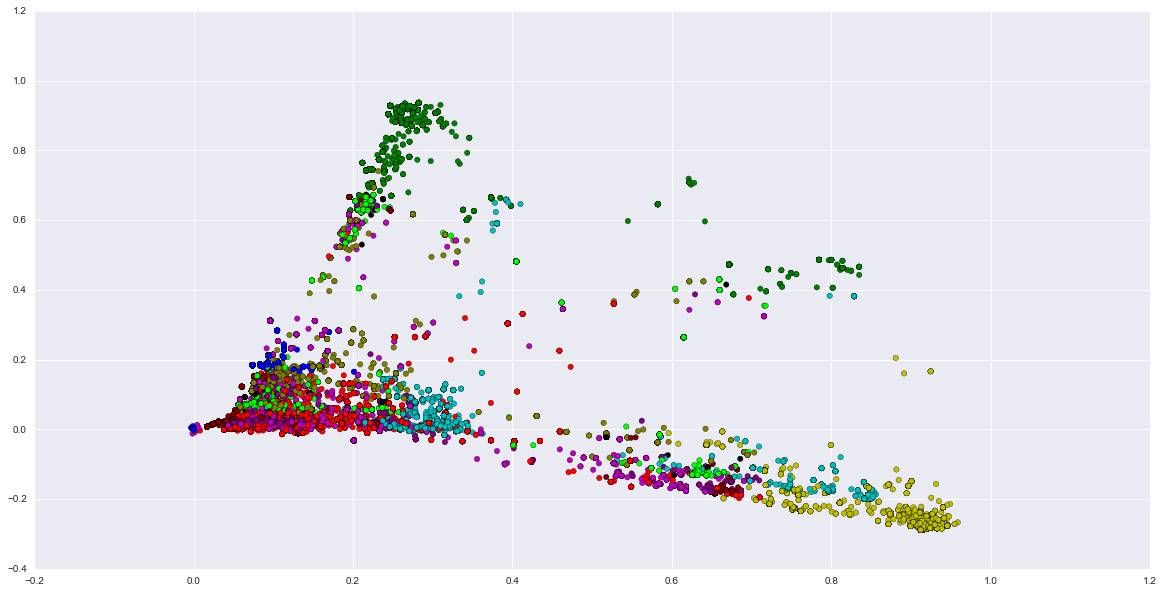

In [335]:
#kmeans = KMeans(n_clusters=12, init='k-means++', max_iter=100, n_init=1, verbose=True)
#y_pred = kmeans.fit(X)
kmeans = MiniBatchKMeans(n_clusters=11, init='k-means++', n_init=1,
                     init_size=1000, batch_size=1000, verbose=False)
#print("Silhouette Coefficient: %0.3f"
#      % metrics.silhouette_score(X, km.labels_, sample_size=1000))

#kmeans = KMeans(init='k-means++', n_clusters=7, n_init=20)
y_pred = kmeans.fit_predict(X)
centroids = kmeans.cluster_centers_
labels = kmeans.labels_
error = kmeans.inertia_
colors = np.array([x for x in ('b', 'g', 'r', 'c', 'm', 'y', 'k', 'purple', 'lime', 'maroon', 'olive', 'pink')])
colors = np.hstack([colors] * 20)

plt.figure(figsize=(20, 10))
plt.scatter(X[:, 0], X[:, 1], s=30, c=colors[y_pred].tolist())
#print "labels:" , labels
#print "error:", error
#print "centroids:", centroids

In [108]:
tweets_df[tweets_df.Text.isnull()]
#tweets_df[pd.isnull(tweets_df)]
print tweets_df.info()
print tweets_df.shape

<class 'pandas.core.frame.DataFrame'>
Int64Index: 429367 entries, 0 to 429366
Data columns (total 9 columns):
User ID        270866 non-null object
Retweets       270873 non-null float64
Favorites      270873 non-null float64
Has_url        270871 non-null float64
Mentions       270852 non-null object
Text           270813 non-null object
Polarity       206309 non-null float64
Popularity     206309 non-null float64
numMentions    206309 non-null float64
dtypes: float64(6), object(3)
memory usage: 32.8+ MB
None
(429367, 9)


In [218]:
#from sklearn.metrics import silhouette_samples, silhouette_score
#silh_avg = silhouette_score(X, y_pred)
tags = np.unique(labels)
nonan_tweets_df = tweets_df.dropna()
nonan_tweets_df['Labels'] = pd.Series(labels, index=nonan_tweets_df.index)
#print nonan_tweets_df.info()
grouped = nonan_tweets_df.groupby('Labels')
print grouped.size()
raw_clusters = []
pop_users = []
clusters = []
for t in tags:
    g = pd.DataFrame(grouped.get_group(t))
    raw_clusters.append(g)
    #pop_users.append(pd.DataFrame(grouped.get_group(t)).sort_values("Popularity", ascending=False)[:5])

for c in raw_clusters:
    byUsers = pd.DataFrame(c.groupby('User ID').sum().sort_values('Popularity', ascending=False))
    clusters.append(byUsers)
    pop_users.append(byUsers[:3])

Labels
0      9867
1     91636
2     20243
3     14811
4     14182
5      9570
6     10746
7     11742
8      8238
9      8976
10     6261
dtype: int64


/Users/Minying/envs/cs591-datamining/lib/python2.7/site-packages/ipykernel/__main__.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [248]:
top_users = []
for p in pop_users:
    print p.index.values[:3]
    top_users.append(int(p.index.values[0]))
    top_users.append(int(p.index.values[1]))
    top_users.append(int(p.index.values[2]))
    
top_users = np.unique(top_users)
print top_users

['6160792' '2845238149' '2791121294']
[2421921523.0 '1038152798' '2421921523']
['1038152798' 332425505.0 '175378976']
['2421921523' 2791121294.0 '2806977060']
['293758378' 524901955.0 '2421921523']
[332425505.0 '1265807251' '20066020']
['2311435027' '2814008060' 2747504632.0]
[246557633.0 7578742.0 14172204.0]
[2814133260.0 2795340192.0 2792513884.0]
[175378976.0 2814008060.0 '24273999']
['2377815434' '2463065714' '467458488']
[   6160792    7578742   14172204   20066020   24273999  175378976
  246557633  293758378  332425505  467458488  524901955 1038152798
 1265807251 2311435027 2377815434 2421921523 2463065714 2747504632
 2791121294 2792513884 2795340192 2806977060 2814008060 2814133260
 2845238149]


In [253]:
twitter = Twython(CONSUMER_KEY, CONSUMER_SECRET, OAUTH_TOKEN, OAUTH_TOKEN_SECRET)
top_obj = get_user_lookup(twitter, top_users.tolist())
for o in top_obj:
    print o['id'], o['followers_count']

6160792 201874
7578742 189
14172204 204
20066020 209
24273999 388
175378976 189638
246557633 197
293758378 76
332425505 130
467458488 1730
524901955 2971
1038152798 118
1265807251 68
2311435027 1678
2377815434 215399
2421921523 1846
2463065714 1080
2747504632 1604
2791121294 3016
2792513884 663
2795340192 535
2806977060 988
2814008060 675
2814133260 70
2845238149 1074


In [267]:
follower_ids = defaultdict(list)

remaining = twitter.get_application_rate_limit_status()['resources']['followers']['/followers/ids']['remaining']
for u in top_users[1:].tolist():
    print remaining
    if remaining < 2:
        print "start waiting ", u
        time.sleep(920)
        print "done waiting"
        
    twitter = Twython(CONSUMER_KEY, CONSUMER_SECRET, OAUTH_TOKEN, OAUTH_TOKEN_SECRET)
    print u
    follower_ids[u] = test(twitter, u)
    twitter = Twython(CONSUMER_KEY, CONSUMER_SECRET, OAUTH_TOKEN, OAUTH_TOKEN_SECRET)
    remaining = twitter.get_application_rate_limit_status()['resources']['followers']['/followers/ids']['remaining']
    print follower_ids.keys()


15
7578742
14
[7578742]
14
14172204
13
[14172204, 7578742]
13
20066020
12
[20066020, 14172204, 7578742]
12
24273999
11
[20066020, 14172204, 7578742, 24273999]
11
175378976
10
9
8
7
6
5
4
3
2
1
start waiting  1459780345613068543
done waiting
15
14
13
12
11
10
9
8
7
6
5
4
3
2
1
start waiting  1416584045391826808
done waiting
15
14
13
12
11
10
9
8
7
6
5
4
3
2
1
[175378976, 20066020, 14172204, 7578742, 24273999]
1
start waiting  246557633
done waiting
246557633
14
[175378976, 246557633, 20066020, 14172204, 24273999, 7578742]
14
293758378
13
[175378976, 246557633, 20066020, 293758378, 14172204, 24273999, 7578742]
13
332425505
12
[175378976, 246557633, 20066020, 332425505, 293758378, 14172204, 24273999, 7578742]
12
467458488
11
[175378976, 246557633, 20066020, 332425505, 293758378, 14172204, 24273999, 7578742, 467458488]
11
524901955
10
[175378976, 246557633, 524901955, 20066020, 332425505, 293758378, 14172204, 24273999, 7578742, 467458488]
10
1038152798
9
[175378976, 246557633, 524901955, 2

In [281]:
print follower_ids[175378976]

[722824443819524096, 2918166682, 721246011369369600, 23972147, 323626600, 3189000228, 540615369, 101417092, 3119755955, 300173607, 143643128, 82405779, 18178957, 2949440396, 1458195248, 18299854, 17850769, 2380683349, 12144942, 4811953092, 901056266, 714530037291159553, 308196210, 216773006, 3330377908, 719334868434300929, 220486009, 2511318390, 24773009, 326469370, 722705731, 2804719111, 721559821476966400, 359779104, 40735362, 2722247756, 4007684352, 254688485, 262168753, 2964962709, 3229800539, 713541223537987585, 29550755, 447355272, 38365934, 281603236, 4828470937, 385677093, 2362329520, 2222348845, 47009747, 710200191874424832, 841346719, 35329249, 246889764, 2198131868, 28727038, 25860277, 2910971, 720326801654816768, 389764212, 4892089761, 34480648, 1634661600, 7258242, 17103002, 438858294, 120154463, 2682746034, 161011548, 390324586, 26903123, 2343425652, 234250483, 2404008998, 4824365482, 65662809, 224047611, 404615748, 707762438460997632, 718192538952273920, 282323293, 16881

In [274]:
len(follower_ids.keys())
for k in follower_ids.keys():
    print k, len(follower_ids[k])

2845238149 1074
2377815434 215458
2814133260 70
2791121294 3017
2311435027 1678
6160792 201847
175378976 189651
332425505 130
2806977060 988
293758378 77
14172204 204
2421921523 1846
467458488 1732
246557633 197
524901955 2972
24273999 388
2795340192 535
2792513884 662
1038152798 118
20066020 209
2463065714 1080
1265807251 68
7578742 190
2747504632 1603
2814008060 674


In [287]:
for p in pop_users:
    _curr = []
    for u in p.index.values:
        print u, len(follower_ids[int(u)])
        _curr.append(follower_ids[int(u)])
    #print len(_curr)
    p['follower_ids'] = np.array(_curr)
    print p.info()

6160792 201847
2845238149 1074
2791121294 3017
<class 'pandas.core.frame.DataFrame'>
Index: 3 entries, 6160792 to 2791121294
Data columns (total 8 columns):
Retweets        3 non-null float64
Favorites       3 non-null float64
Has_url         3 non-null float64
Polarity        3 non-null float64
Popularity      3 non-null float64
numMentions     3 non-null float64
Labels          3 non-null int32
follower_ids    3 non-null object
dtypes: float64(6), int32(1), object(1)
memory usage: 204.0+ bytes
None
2421921523.0 1846
1038152798 118
2421921523 1846
<class 'pandas.core.frame.DataFrame'>
Index: 3 entries, 2421921523.0 to 2421921523
Data columns (total 8 columns):
Retweets        3 non-null float64
Favorites       3 non-null float64
Has_url         3 non-null float64
Polarity        3 non-null float64
Popularity      3 non-null float64
numMentions     3 non-null float64
Labels          3 non-null int32
follower_ids    3 non-null object
dtypes: float64(6), int32(1), object(1)
memory usage:

/Users/Minying/envs/cs591-datamining/lib/python2.7/site-packages/ipykernel/__main__.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [290]:
print pop_users[0].follower_ids

User ID
6160792       [722983125320527873, 4722163532, 7229709015164...
2845238149    [722060351228010496, 490587661, 4228515238, 37...
2791121294    [718246085190414337, 43287329, 722874740826701...
Name: follower_ids, dtype: object


In [292]:
nonan_tweets_df.to_csv("clustered_tweets.csv", sep="\t", encoding='utf-8')

In [295]:
all_pop_users = pd.concat([x for x in pop_users], ignore_index=False)
print all_pop_users.info()

<class 'pandas.core.frame.DataFrame'>
Index: 33 entries, 6160792 to 467458488
Data columns (total 8 columns):
Retweets        33 non-null float64
Favorites       33 non-null float64
Has_url         33 non-null float64
Polarity        33 non-null float64
Popularity      33 non-null float64
numMentions     33 non-null float64
Labels          33 non-null int32
follower_ids    33 non-null object
dtypes: float64(6), int32(1), object(1)
memory usage: 2.2+ KB
None


In [297]:
all_pop_users.to_csv("all_pop_users.csv", sep="\t", encoding='utf-8')

In [323]:
all_users = set(nonan_tweets_df['User ID'].tolist())

for i in range(len(pop_users)):
    F_IN_C = []
    F_IN_DF = []
    followers = pop_users[i]['follower_ids'].tolist()
    cluster_users = set(clusters[i].index.tolist())
    for fol in followers:
        f_in_df = []
        f_in_cluster = []
        for f in fol:
            if f in cluster_users:
                f_in_cluster.append(f)

            if f in all_users:
                f_in_df.append(f)
        
        F_IN_C.append(f_in_cluster)
        F_IN_DF.append(f_in_df)
    
    pop_users[i]['Followers In Cluster'] = F_IN_C
    pop_users[i]['Followers In df'] = F_IN_DF

print pop_users[0].info()
print pop_users[10].info()

/Users/Minying/envs/cs591-datamining/lib/python2.7/site-packages/ipykernel/__main__.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/Minying/envs/cs591-datamining/lib/python2.7/site-packages/ipykernel/__main__.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


<class 'pandas.core.frame.DataFrame'>
Index: 3 entries, 6160792 to 2791121294
Data columns (total 10 columns):
Retweets                3 non-null float64
Favorites               3 non-null float64
Has_url                 3 non-null float64
Polarity                3 non-null float64
Popularity              3 non-null float64
numMentions             3 non-null float64
Labels                  3 non-null int32
follower_ids            3 non-null object
Followers In Cluster    3 non-null object
Followers In df         3 non-null object
dtypes: float64(6), int32(1), object(3)
memory usage: 252.0+ bytes
None
<class 'pandas.core.frame.DataFrame'>
Index: 3 entries, 2377815434 to 467458488
Data columns (total 10 columns):
Retweets                3 non-null float64
Favorites               3 non-null float64
Has_url                 3 non-null float64
Polarity                3 non-null float64
Popularity              3 non-null float64
numMentions             3 non-null float64
Labels               

In [343]:
for p in pop_users:
    ratios = []
    counts = []
    for i in range(len(p)):
        r = len(p['Followers In Cluster'][i]) * 1.0 / len(p['Followers In df'][i])
        c = len(p['follower_ids'][i])
        ratios.append(r)
        counts.append(c)
    p['Ratio'] = ratios
    p['follower_count'] = counts


/Users/Minying/envs/cs591-datamining/lib/python2.7/site-packages/ipykernel/__main__.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/Minying/envs/cs591-datamining/lib/python2.7/site-packages/ipykernel/__main__.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [351]:
for p in pop_users:
    for i in p:

TypeError: string indices must be integers, not str